# Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage

présenté par : 
- Branis GHOUL 
- 28612738

### Introduction:

Lorsque les humains voient l'image d'un humain ou d'un animal particulier, nous pouvons reconnaître cette image même lorsque son orientation est modifiée ou tournée. La raison en est que, en tant qu'êtres humains, nous pouvons facilement identifier les points clés cruciaux d'une image donnée. Ainsi, même si l'image est tournée, nous pouvons toujours l'identifier et la relier à l'image d'origine car notre cerveau peut comprendre les points clés. De même, nous avons besoin de points clés lors du traitement des images sur l'ordinateur pour identifier les points importants d'une image. 

Pendant qu'un ordinateur effectue un traitement d'image, l'ordinateur doit être capable d'identifier des caractéristiques similaires dans une image donnée, quelles que soient les transformations et les rotations qu'elle subit.

L'ordinateur devrait même être capable de trouver des similitudes entre différentes images appartenant à une même catégorie. Ceci est possible en observant les points clés d'une image donnée.  

Par exemple, pour un visage humain, les points clés sont les deux coins des yeux, les deux coins de la bouche, le menton et le bout du nez.  

L'idée principale est que malgré tous les changements dans une image, l'ordinateur devrait retrouver les mêmes points clés dans la nouvelle image.  

L'ordinateur étudie les valeurs de pixel entourant un point clé donné et l'identifie lorsque les images sont modifiées.

L’objectif de ce TP est de réaliser une méthode d’alignement de points caractéristiques du visage inspirée de `https://www.ri.cmu.edu/pub_files/2013/5/main.pdf`



### Importer les librairies nécessaires 

In [1]:
import os 
import numpy as np
import zipfile
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFont
import cv2
from tqdm import tqdm
import random
import sys 
import time

# import win32file
# win32file._setmaxstdio(2048)

%matplotlib inline 

### 1 Préparation des données

Dans un premier temps, nous allons devoir préparer les données qui permettront d’apprendre et d’évaluer notre méthode d’alignement.

##### 1.1 Téléchargement des données

Cette base est la réunion de 4 sous ensembles de données `(Helen, AFW, LFPW et IBug)` dont les images (extension `.jpg` ou `.png`) et les annotations (extension `.pts`) sont contenues dans les repertoires du même nom. Nous trouverons également des fichiers `.txt` contenant la liste des données à utiliser pour l’apprentissage `–300w_train_images.txt` et `300w_train_landmarks.txt` respectivement pour la liste des images et des annotations– ainsi que pour les tests.  

In [2]:
# # Download zip file of dataset
# !wget https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download


In [3]:
# Extract the current path
current_path = os.path.dirname(os.path.abspath('__file__'))
current_path


'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\PW3_alignment_of_characteristic_points_of_the_face'

In [4]:
# Full path of the dataset
name_dataset_file = '300w.zip'
path_dataset = os.path.join(current_path, 'data', name_dataset_file)
path_dataset

'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\PW3_alignment_of_characteristic_points_of_the_face\\data\\300w.zip'

In [5]:
# Unzip the downloaded file
def unzip_file(path=r'data\300w.zip'):
  zip_ref = zipfile.ZipFile(path, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
unzip_file(path=path_dataset)

##### 1.2 Visualisation des données


Pour prendre en main les données, la première étape consiste à `parser` le fichier `300w_train_images.txt` et à afficher aléatoirement une dizaine d’images avec les points caractéristiques correspondants.  

In [7]:
# create dataset 
def create_dataset(path_images=r'300w_train_images.txt', 
                   path_landmarks=r'300w_train_landmarks.txt'):

  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  images, landmarks = [], []
  for path_image, path_landmark in tqdm(zip(path_all_images, path_all_landmarks)):
    # open method used to open different extension image file
    images.append(Image.open(path_image.strip()))
    landmarks.append(np.loadtxt(path_landmark.strip(), dtype=float))
    
    # with open(path_landmark.strip()) as f:
    #   line = f.readlines()
    # landmarks.append([[float(l.strip().split(' ')[0]), float(l.strip().split(' ')[1])] for l in line])

  return (images, np.array(landmarks, dtype=object))

In [7]:
train_images, train_landmarks = create_dataset(path_images=r'.\300w_train_images.txt', 
                                               path_landmarks=r'.\300w_train_landmarks.txt')

3148it [00:31, 100.47it/s]


In [8]:
len(train_images), train_landmarks.shape

(3148, (3148, 68, 2))

In [8]:
def extract_coordinates_bounding_box( image, 
                                      landmarks, 
                                      expansion_rate=0.3):
  expansion_rate /= 2
  w, h = image.size

  x_max, y_max = landmarks[:, 0].max(), landmarks[:, 1].max()
  x_min, y_min = landmarks[:, 0].min(), landmarks[:, 1].min() 

  x_max, y_max = x_max + expansion_rate*(x_max-x_min), y_max + expansion_rate*(y_max-y_min)
  x_min, y_min = x_min - expansion_rate*(x_max-x_min), y_min - expansion_rate*(y_max-y_min)

  x_max, y_max = np.clip(x_max, a_max=w, a_min=None), np.clip(y_max, a_max=h, a_min=None)
  x_min, y_min = np.clip(x_min, a_max=None, a_min=0), np.clip(y_min, a_max=None, a_min=0)

  return (x_max, y_max, x_min, y_min)


def vew_images( images, 
                landmarks=None, 
                nb_images=16,
                random_display=True, 
                grid=False, 
                total_cols=4, 
                s=5, 
                bounding_box=True, 
                color='red', 
                expansion_rate=0.3,
                title='', 
                figsize=(10, 10)):
                
  # read random images
  if random_display:
    indexes = random.sample(range(len(images)), nb_images)
  else: 
    indexes = range(nb_images)


  # compute number of cols & row  
  total_cols = min(nb_images, total_cols)
  total_rows = int(nb_images / total_cols) + (1 if nb_images % total_cols != 0 else 0)

  # Create a grid of subplots.
  fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)

  # Create list of axes for easy iteration.
  if isinstance(axes, np.ndarray):
      # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
      list_axes = list(axes.flat)
  else:
      list_axes = [axes]
  
  fig.suptitle(title)
  # it will helps to show total images as grid 
  for nb_ax, rand_id in zip(range(nb_images), indexes):
      img = images[rand_id].copy() 
      ld_marks = landmarks[rand_id].copy()

      if ld_marks.all() != None:
        list_axes[nb_ax].scatter(ld_marks[:, 0], ld_marks[:, 1], s=s)
      
      if bounding_box:
        x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
        ImageDraw.Draw(img).rectangle([(x_max, y_max), (x_min, y_min)], outline=color, width=s)
      
      list_axes[nb_ax].imshow(img, cmap='gray')
      list_axes[nb_ax].grid(grid)
      list_axes[nb_ax].set_axis_off()
      # list_axes[i].set_title(f'label {label}')

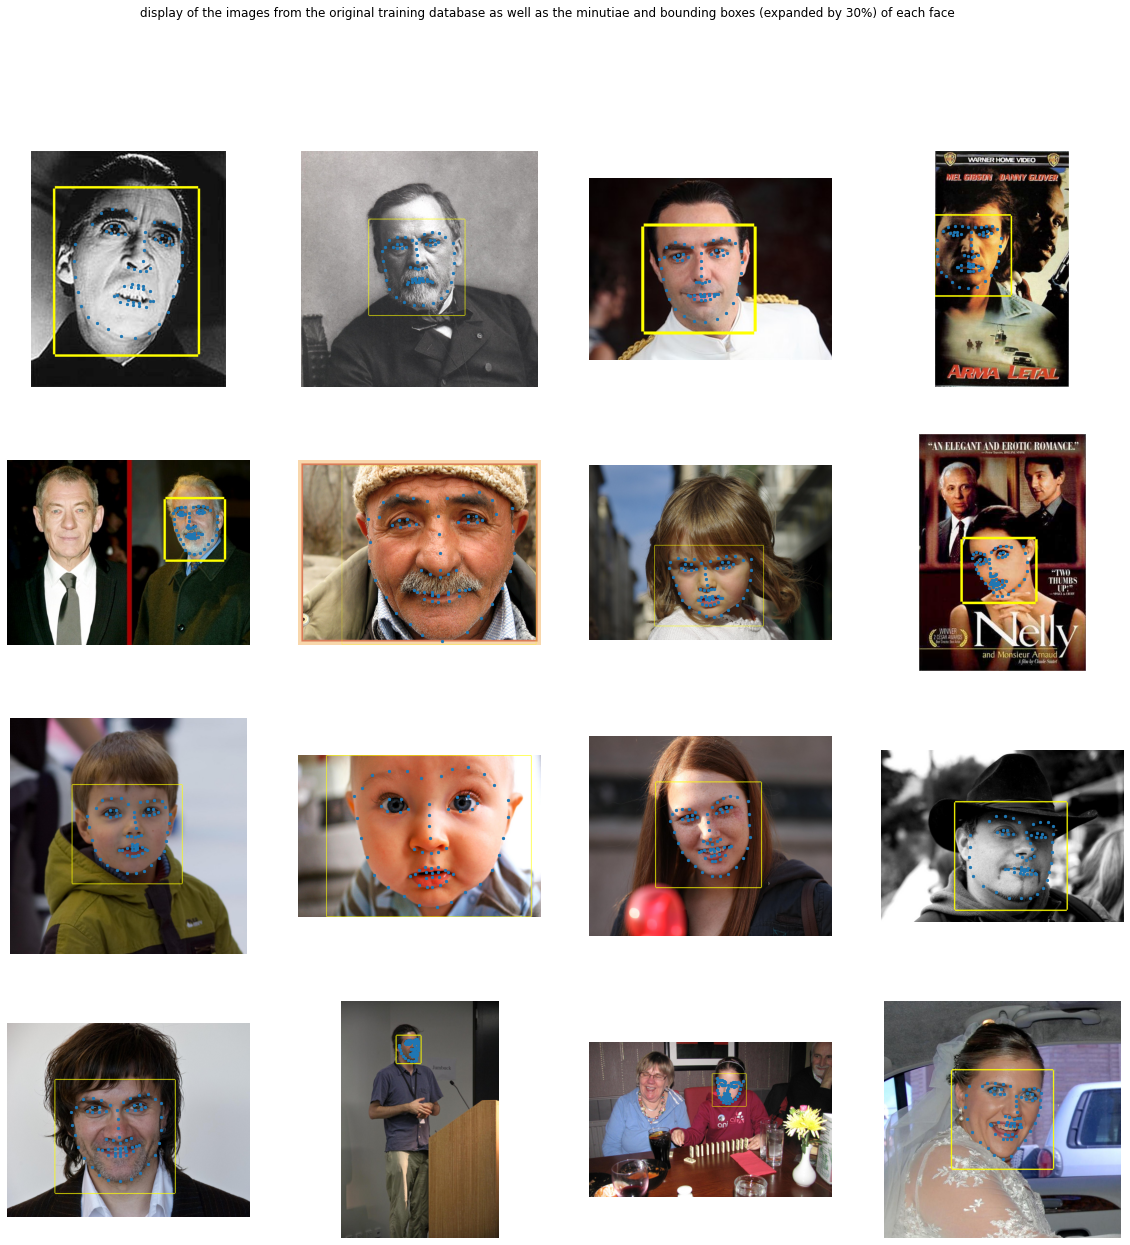

In [11]:
vew_images( images=train_images, 
            landmarks=train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images from the original training database as well as the minutiae and bounding boxes (expanded by 30%) of each face', 
            figsize=(20, 20)    )

Ici, nous affichons 16 images aléatoires de la base de données d'entraînement. À chaque exécution de la cellule ci-dessous nous affichons 16 nouvelles images avec les points caractéristiques et les boites englobantes. Ainsi, nous avons une meilleure idée des images constituant la base de données. Cependant, nous avons remarqué que certains des points caractéristiques sont situés aux extrémités des dimensions des images. Par conséquent, nous ne pouvons pas agrandir les boîtes de délimitation des points caractéristiques dans ces cotés.

##### 1.3 Augmentation des données

Pour chaque image de l’ensemble d’apprentissage, nous devons :  
    1. Calculer les paramètres de la boite englobante des points caractéristiques du visage.    
    2. Elargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, redimensionner l’image en `128 ∗ 128` et enregistrer l’image.    
    3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. La position des points constituera la vérité terrain (nous afficherons l’image et les points caractéristique pour vérifier que ce prétraitement est effectif).  
    4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage.  
    5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations (indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une méthode automatique pour déterminer l’amplitudes de ces déplacements ?    

A la fin de cette étape nous disposons des données d’apprentissage dont nous aurons besoin pour apprendre notre modèle. Nous appliquons les mêmes transformations aux images de test (sans les perturbations aléatoires) afin d’être dans les mêmes conditions pour l’évaluation.  

In [9]:
# This function processes questions 1.3.1 to 1.3.4
def create_usable_dataset(path_images, 
                          path_landmarks, 
                          registration_root_path, 
                          name_folder, 
                          expansion_rate=0.3): 
  
  """
  1. Calculer les paramètres de la boite englobante des points caractéristiques du visage.
  2. Elargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, 
     redimensionner l’image en `128 ∗ 128` et enregistrer l’image.
  3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. 
     La position des points constituera la vérité terrain (vous afficherez l’image et 
     les points caractéristique pour vérifier que ce prétraitement est effectif).  
  4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage.
  """

  registration_path = os.path.join(registration_root_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  for i, path_image, path_landmark in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
    
    img = Image.open(path_image.strip())
    ld_marks = np.loadtxt(path_landmark.strip(), dtype=float, encoding='bytes')

    id_no = time.strftime('%Y%m%d_%H%M%S', time.localtime()) + str(i) + \
            str(random.randint(10000 + i, 99999 - i )) 

    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
    img = img.crop((x_min, y_min, x_max, y_max)).resize((128, 128))    
    w2, h2  = img.size
    img.save(os.path.join(registration_path, "sample_{:05d}.png".format(i)))
    img.close()
    
    ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] - x_min, ld_marks[:, 1] - y_min
    ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] * w2/(x_max-x_min), ld_marks[:, 1] * h2/(y_max-y_min)
    np.savetxt(os.path.join(registration_path, "sample_{:05d}.pts".format(i)), ld_marks)

In [13]:
create_usable_dataset(path_images=r'.\300w_train_images.txt', 
                      path_landmarks=r'.\300w_train_landmarks.txt', 
                      registration_root_path='.', 
                      name_folder='new_dataset', 
                      expansion_rate=0.3)

3148it [01:53, 27.77it/s]


In [10]:
def extract_file_path_dataset(path_dataset, 
                              name_backup_folder):
  try : 
    os.mkdir(os.path.join(name_backup_folder))
  except FileExistsError as e:
    print(e), sys.exit()

  path_images, path_landmarks = [], []
  for file_name in os.listdir(path_dataset):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):
      path_images.append(os.path.join(path_dataset, file_name))
    if file_name.endswith('.pts'):
      path_landmarks.append(os.path.join(path_dataset, file_name))

  with open(os.path.join(name_backup_folder, '300w_train_images.txt'), 'w') as fi, \
       open(os.path.join(name_backup_folder, '300w_train_landmarks.txt'), 'w') as fl:
    for pth_img, pth_ldmks in zip(path_images, path_landmarks):
      # write each item on a new line
      fi.write(f"{pth_img}\n")
      fl.write(f"{pth_ldmks}\n")
   

In [16]:
extract_file_path_dataset(path_dataset=r'new_dataset', 
                          name_backup_folder=r'paths_of_new_dataset')

In [10]:
new_train_images, new_train_landmarks = create_dataset(path_images=os.path.join(current_path, r'paths_of_new_dataset\300w_train_images.txt'), 
                                                       path_landmarks=os.path.join(current_path, r'paths_of_new_dataset\300w_train_landmarks.txt'))


3148it [00:10, 297.57it/s]


In [12]:
len(new_train_images), new_train_landmarks.shape

(3148, (3148, 68, 2))

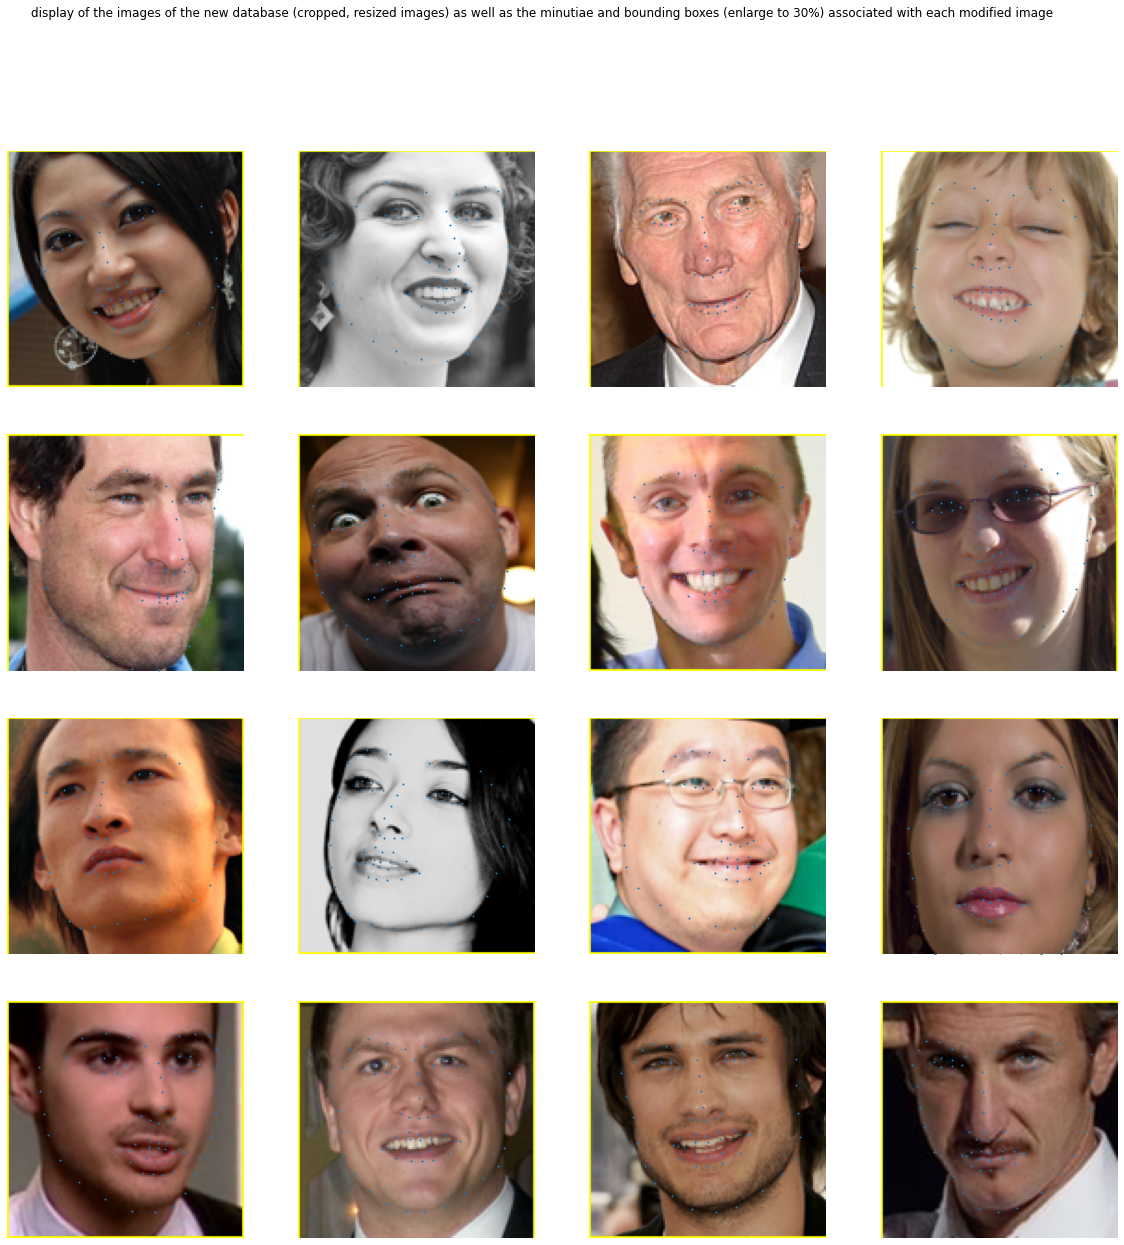

In [19]:
vew_images( images=new_train_images, 
            landmarks=new_train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=1, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3,
            title='display of the images of the new database (cropped, resized images) as well as the minutiae and bounding boxes (enlarge to 30%) associated with each modified image ',  
            figsize=(20, 20))

Ici, nous avons coper, resisee 

In [21]:
new_train_images[0].size

(128, 128)

In [13]:
# This function processes questions 1.3.5
def generation_of_disturbed_data( path_images, 
                                  path_landmarks, 
                                  full_path, 
                                  name_folder, 
                                  disruption_factor=(-20, 20), 
                                  expansion_rate=0.0, 
                                  nb_disturbances=10): 
  
  """
    5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle)
       et enregistrer chacune de ces réalisations L’amplitude de ces déformations sera de ±20% pour le facteur d’échelle et 
       ±20px pour les translations (indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une méthode 
       automatique pour déterminer l’amplitudes de ces déplacements ?
  """
  
  registration_path = os.path.join(full_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  min_disruption, max_disruption = disruption_factor 
  
  for i, path_image, path_landmark in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
    img_ = Image.open(path_image.strip())
    ld_ = np.loadtxt(path_landmark.strip(), dtype=float, encoding='bytes')
    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img_, ld_, expansion_rate)
    w, h = img_.size

    for j in range(i*nb_disturbances, nb_disturbances*(i+1), 1):
      scale_rate = np.random.randint(min_disruption, max_disruption) / 100 
      translation_rate = (np.random.randint(min_disruption, max_disruption), 
                          np.random.randint(min_disruption, max_disruption))

      x_translation = ld_[:, 0] + translation_rate[0]
      y_translation = ld_[:, 1] + translation_rate[1]

      if  np.all(x_translation >= 0) and np.all(x_translation < w):
        ld_[:, 0] = x_translation
      if  np.all(y_translation >= 0) and np.all(y_translation < h):
        ld_[:, 1] =  y_translation
      
      scale_transforamtion = ld_ - (ld_ * scale_rate)

      if  np.all(scale_transforamtion[:, 0] >= 0)  and np.all(scale_transforamtion[:, 0] < w) and \
          np.all(scale_transforamtion[:, 1] >= 0)  and np.all(scale_transforamtion[:, 1] < h):
        ld_ = scale_transforamtion
      
      id_no = time.strftime('%Y%m%d_%H%M%S', time.localtime()) + str(j) + \
              str(random.randint(10000 + i, 99999 - i ))
      img_.save(os.path.join(registration_path, "sample_{:05d}.png".format(j)))
      np.savetxt(os.path.join(registration_path,"sample_{:05d}.pts".format(j)), ld_)
    img_.close()


  


In [14]:
generation_of_disturbed_data(   path_images=r'paths_of_new_dataset\300w_train_images.txt', 
                                path_landmarks=r'paths_of_new_dataset\300w_train_landmarks.txt', 
                                full_path='.', 
                                name_folder='data_disturbed', 
                                disruption_factor=(-20, 20), 
                                expansion_rate=0.0,
                                nb_disturbances=2  )

3148it [00:58, 53.76it/s]


In [12]:
extract_file_path_dataset(path_dataset=r'data_disturbed', name_backup_folder=r'paths_of_data_disturbed')

In [11]:
train_images_disturbed, train_landmarks_disturbed = create_dataset(path_images=r'paths_of_data_disturbed\300w_train_images.txt', 
                                                                  path_landmarks=r'paths_of_data_disturbed\300w_train_landmarks.txt')

6296it [00:13, 474.74it/s] 


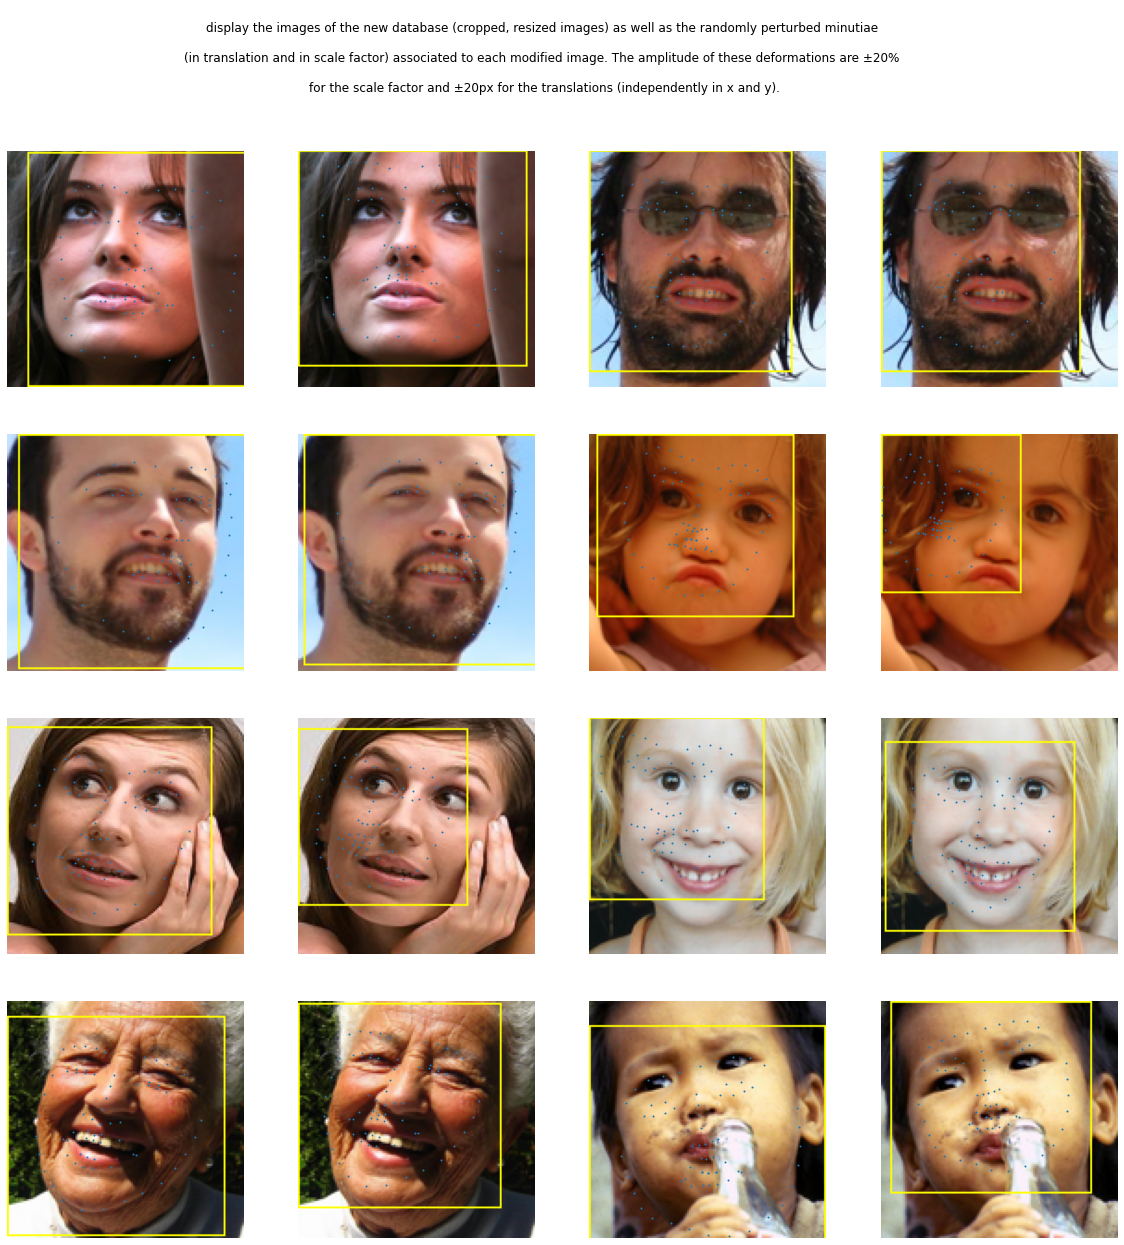

In [12]:
vew_images( images=train_images_disturbed, 
            landmarks=train_landmarks_disturbed, 
            nb_images=16,
            random_display=False, 
            grid=False, 
            total_cols=4, 
            s=1, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3,
            title="""
display the images of the new database (cropped, resized images) as well as the randomly perturbed minutiae \n
(in translation and in scale factor) associated to each modified image. The amplitude of these deformations are ±20% \n
for the scale factor and ±20px for the translations (independently in x and y).
""", 
            figsize=(20, 20))

In [28]:
np.random.randint(-20, 20)

-20

## 2. Apprentissage d’un régresseur simple

Dans cette partie, nous souhaitons estimer un **déplacement** des points caractéristiques à
partir d’un modèle de points moyen, i.e. apprendre en utilisant des outils élémentaires de
l’apprentissage statistique et de la vision par ordinateur, une fonction $f : I, s0 → δs$ telle que
$s0 + δs ≈ s∗$ au sens des moindres carrés.

### 2.1 Extraction de caractéristiques image

Pour ce faire, une première étape consiste à $abstraire$ localement (i.e. au voisinage de chaque
point caractéristique) la représentation image.

1. Pourquoi ne peut-on pas utiliser directement les valeurs des pixels de l’image comme représentation?  

Les valeurs des pixels ne capturent pas toutes les informations d'une image. Elles ignorent la couleur et la texture de l'image, ainsi que d'autres caractéristiques qui pourraient être utiles pour cerner le contenu de l'image. En utilisant un discréteur, ces caractéristiques peuvent être capturées et transformées en une représentation numérique plus précise et plus facilement manipulable.  

Un bon discréteur doit être capable de capturer le contenu des images de manière précise et fiable. Il devrait également être robuste et pouvoir résister aux variations dans les conditions d'imagerie (rotation, translation, changements brusques de luminance, etc.) tout en conservant sa précision. Un bon discréteur devrait également être rapide à calculer et à intégrer à un programme, sans compromettre la qualité ou le temps de traitement.  

2. Créer, pour chaque point caractéristique courant du modèle moyen si 0i=0,...,68, un objet cv2.keyPoint en spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. Quel est la dimensionnalité de chacun de ces descripteurs?

Il existe de nombreux discréteurs qui peuvent être utilisés pour le traitement d'image. Nous alons utliser le discréteur `SIFT` (Scale-Invariant Feature Transform),ce denrnier est un algorithme de détection et de description des points caractéristiques appliqué au traitement d'image. Il permet d'extraire des informations spécifiques telles que les couleurs, les textures et les contours. Le SIFT est très populaire pour ses performances élevées.  

Le Discréteur SIFT a une dimension de 128. Chaque point caractéristique détecté par le SIFT est représenté par un vecteur de 128 dimensions composé de clefs, orientations et lignes équilibrées sur le plan de l'image. Ces informations sont ensuite utilisées pour comparer les points caractéristiques trouvés entre les images.  

Voici le principe de l'algorithme SIFT (Scale Invariant Feature Tracking) :  
- Dans un bloc de 16 × 16 pixels autour d’un point d’intérêt.
- Réorienter les gradients de sorte que l’orientation principale du bloc soit de 0° (par exemple).
- Diviser le bloc en 4 × 4 sous-blocs.
- Pour chaque bloc, calculer l’histogramme des gradients (pondérés par leur norme) : utiliser un faible nombre de bins (généralement 8) 4 Concat´ener les 16 histogrammes ⇒ descripteur / vecteur caract´eristique de 16 × 8 = 128 dimensions.  
- Normaliser le vecteur caract´eristique (norme L2).  

4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. Quelle est la dimension de ce descripteur?

Après concaténation de l'ensemble des descripteurs pour chaque point, nous obtenons une dimension de `68 * 128`, comme nous avons traité 3148 images, la matrice finale est de dimension `(3148 * 8074)`. 

5. Citer deux exemples de représentation image qui pourraient être utilisés à la place des descripteurs SIFT, en expliquant brièvement le principe sous-jacent.

Deux exemples de représentations image qui peuvent être utilisés à la place des descripteurs SIFT sont le Discréteur de Binarisation de Noyau et le Discréteur de Histogramme Locaux Orientés. Le discréteur BIN est un algorithme basé sur les noyaux qui extrait des caractéristiques spécifiques à une image, tandis que le discréteur HLO est utilisé pour extraire des informations telles que les couleurs, les textures et les contours d'une image.

In [20]:
def feature_extraction(path_images, path_landmarks, size):
    """
    2. Créer, pour chaque point caractéristique courant du modèle moyen si 0i=0,...,68, un objet cv2.keyPoint en 
    spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant le diamètre du voisinage) de 20 pixels.

    3. Utiliser la fonction sift.compute de opencv pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. 
    Quel est la dimensionnalité de chacun de ces descripteurs?

    4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. 
    Quelle est la dimension de ce descripteur?
    """

    with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
        path_all_images = file_images.readlines()
        path_all_landmarks = file_landmarks.readlines()
    
    descriptors = []
    sift = cv2.SIFT_create()
    for i, path_image, path_landmarks in tqdm(zip(range(len(path_all_images)), path_all_images, path_all_landmarks)):
        image = cv2.imread(path_image.strip(), 0)
        landmarks = np.loadtxt(path_landmarks.strip(), dtype=float)

        key_points = [cv2.KeyPoint(x=ld[0], y=ld[1], size=size) for ld in landmarks]
        _, siftt = sift.compute(image, key_points)
        descriptors.append(siftt)


    return np.array(descriptors).reshape(len(path_all_images), -1)
        


In [21]:
descriptors = feature_extraction(path_images=r'.\paths_of_new_dataset\300w_train_images.txt', 
                                 path_landmarks=r'.\paths_of_new_dataset\300w_train_landmarks.txt', 
                                 size=20)


3148it [01:00, 52.15it/s]


In [22]:
# 3148, 68, 128 --> 3148, 68*128, --> 3148, 8704
descriptors.shape

(3148, 8704)

##### 2.2 Réduction de dimensionalité

1. Quel est l’intérêt principal de la réduction de dimensionalité en machine learning? 
   Quelles sont les principales méthodes de réduction de dimensionalité?

La réduction de dimensionalité en machine learning a deux principaux avantages. Premièrement, elle permet de réduire le temps et la puissance de traitement nécessaires pour effectuer des analyses et des prédictions sur un jeu de données. En second lieu, elle permet d'améliorer la précision des prédictions car elle réduit le bruit et élimine les attributs qui ne sont pas pertinents.  

Les principales méthodes de réduction de dimensionalité sont l'analyse en composantes principales (PCA), la factorisation matricielle, le filtrage des variables, la regression linéaire, la selection d'attributs basée sur les scores et l'apprentissage non supervisé. Chaque méthode a ses propres avantages et inconvénients, et peut être plus ou moins adaptée à des tâches spécifiques.  

2. Utiliser l’analyse en composante principale (ACP ou PCA en anglais - librairies opencv
ou skimage, au choix) en conservant 98% de la variance totale des descripteurs.

3. Quelles sont les dimensions de la matrice X˜ 0 obtenue par réduction de dimensionalité?

In [24]:
from sklearn.decomposition import PCA

In [41]:
my_model = PCA(n_components=0.98, svd_solver='full')
x0_ = my_model.fit_transform(descriptors)

In [62]:
x0_.shape

(3148, 691)

##### 2.3 Estimation du déplacement


Maintenant que nous disposons de représentations images locales compressées pour chaque image de la base de donnée $X^*_0 = A_0 X_0$, nous souhaitons estimer une régression linéaire permettant de prédire un déplacement de l’ensemble des points caractéristiques $δ_s$ à partir de ces représentation. Formellement, ce déplacement vérifie.

1. Calculer la matrice $Y^˜_0$, la matrice de déplacements $δ^∗_s$.  

In [14]:
np.ones(x0_.shape[-1])

array([1., 1., 1., ..., 1., 1., 1.])

In [43]:
y_ = np.concatenate((x0_, np.array([np.ones(x0_.shape[-1])])), axis=0)
y_.shape

(3149, 691)

In [45]:
original_image, original_landmarks = new_train_images[0], new_train_landmarks[0]
disturbed_image, disturbed_landmarks = Image.open(r'.\data_disturbed\sample_00000.png'), \
                                       np.loadtxt(r'.\data_disturbed\sample_00000.pts', dtype=float)
# disturbed_image, disturbed_landmarks = train_images_disturbed[0], train_landmarks_disturbed[0]

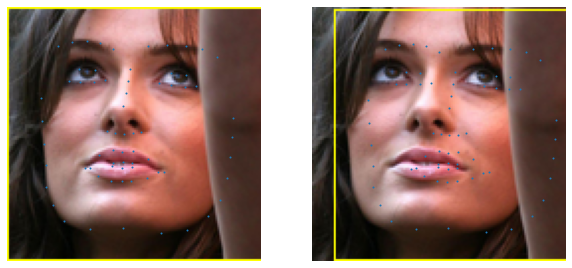

In [46]:
vew_images( images=[original_image, disturbed_image], 
            landmarks=np.array([original_landmarks, disturbed_landmarks]), 
            nb_images=2,
            random_display=False,  
            s=1, 
            color='yellow', 
            figsize=(10, 10))

In [54]:
delta_opt = np.abs(original_landmarks - disturbed_landmarks)
delta_opt = delta_opt.reshape(-1, 1) 
delta_opt.shape

(136, 1)

In [63]:
R = np.random.randn(136, y_.shape[1]+1)
R.max(), R.min(), R.shape

(5.318610551152295, -4.129412174125725, (136, 692))

In [ ]:
np.linalg.lstsq(y, b, rcond='warn')

2. Calculer $R_0$ en appliquant une résolution aux moindres carrés et le déplacement $R_0Y^˜_0$ pour chaque image (ou chaque ligne).


3. Calculer l’erreur $δ^∗_s − R_0Y^˜_0$ et afficher, pour la première image de la base, les points caractéristiques initiaux $s_0$ (en vert) ainsi que les points déplacées $s_0 + δ_s$. Que peut-on en conclure?

In [37]:
"""
delta =      R      @      Y
136   = 136x(M'+1)      (M'+1)xN  [i]

il faut avoire toutes les images/ladmarks originaux et deformées (en calculant le modèle moyen)
"""


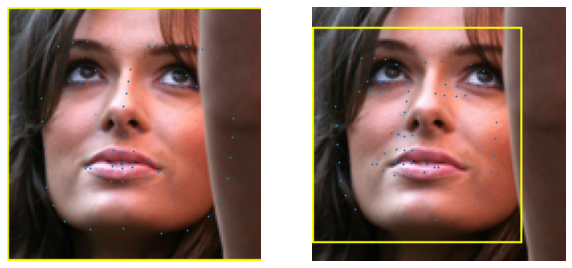